In [1]:
!pip install einops diffusers

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [27]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
import einops
from torch.utils.tensorboard import SummaryWriter


In [28]:
if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available.")

GPU is not available.


In [29]:
# config
TRAIN = True

IMAGE_SIZE = 16
MODEL_PATH = Path('./models')
LOG_PATH = Path('./logs')
EPOCHS = 100
BATCHS = 32
EPOCH_STEPS = 1000
PATIENCE = 100

if not MODEL_PATH.exists():
    MODEL_PATH.mkdir()
if not LOG_PATH.exists():
    LOG_PATH.mkdir()

if torch.cuda.is_available():
    DEVICE='cuda'
else:
    DEVICE='cpu'

T = 1000 # 时间步长
𝛃 = torch.linspace(0.0001, 0.02, T).to(DEVICE) # 扩散率
𝛂 = 1 - 𝛃
ᾱ = 𝛂.cumprod(dim=0) # 累乘


transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# load minist
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

dataiter = iter(train_data)
DEVICE

'cpu'

In [30]:
# show images
def imshow(img):
    npimg = img.numpy()
    npimg = einops.rearrange(npimg, 'c h w->h w c')
    plt.imshow(npimg, cmap='gray')
    plt.show()
    
def imshows(imgs, shape):
    fig, axs = plt.subplots(shape[0], shape[1], figsize=(shape[0]*2, shape[1]*2))
    for i in range(shape[0]):
        for j in range(shape[1]):
            image = einops.rearrange(imgs[i*shape[1]+j], 'c h w->h w c')
            if shape[0] > 1:
                axs[i, j].imshow(image, cmap='gray')
                axs[i, j].axis('off')
            else:
                axs[j].imshow(image, cmap='gray')
                axs[j].axis('off')
    plt.show()

torch.Size([1, 16, 16]) 5 tensor(-1.) tensor(0.9216)


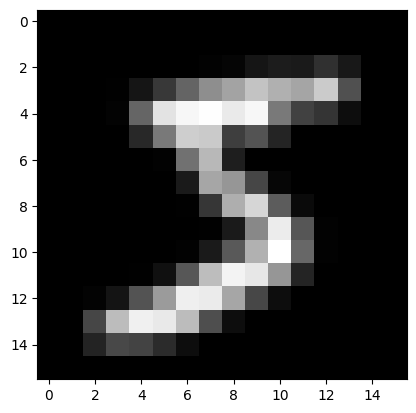

In [31]:
# show some images
image, label = next(dataiter)
print(image.shape, label, image.min(), image.max())
imshow(image)

# sample

## noisy_sample

get sample using random timesteps

## noisy_sample_one

get one sample using specify timestep

In [32]:
def noisy_sample(x0, ᾱ, num_sample=3):
    t = torch.randint(0, T, (num_sample,), dtype=torch.long)
    ε = torch.normal(0, 1, (num_sample, 1, IMAGE_SIZE, IMAGE_SIZE)).to(DEVICE)
    ᾱ_t = ᾱ[t].reshape(num_sample, 1, 1, 1)
    xt = (x0[None,...] * ᾱ_t.sqrt() + (1-ᾱ_t).sqrt() * ε)
    xt = (xt - 0.5)/0.5

    return xt, t, ε

def noisy_sample_one(x0, ᾱ, t=1):
    t = torch.tensor(t, dtype=torch.long).to(DEVICE)
    ε = torch.normal(0, 1, (1, 1, IMAGE_SIZE, IMAGE_SIZE)).to(DEVICE)
    ᾱ_t = ᾱ[t].reshape(1, 1, 1, 1)
    xt = (x0 * ᾱ_t.sqrt() + (1-ᾱ_t).sqrt() * ε)

    xt = (xt - 0.5)/0.5
    return xt, ε

In [33]:
image = image.to(DEVICE)
xt, t, noisy = noisy_sample(image, ᾱ, 9)
xt.shape, t.shape, noisy.shape, xt.min(), xt.max()

(torch.Size([9, 1, 16, 16]),
 torch.Size([9]),
 torch.Size([9, 1, 16, 16]),
 tensor(-6.9345),
 tensor(5.9083))

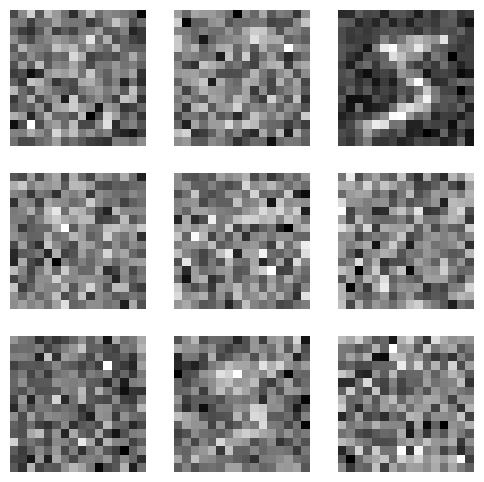

In [34]:
xt_mi = xt.min()
xt_ma = xt.max()
imshows(((xt-xt_mi)/(xt_ma-xt_mi)).cpu() , (3,3))

In [16]:
!pwd
!ls models

/home/test/work/project/code


In [36]:
from diffusers import UNet2DModel


## using diffusers UNet2DModel, since I dont care about the details of the unet
class my_model(torch.nn.Module):
    def __init__(self):
        super(my_model, self).__init__()
        # in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8
        self.model = UNet2DModel(
            sample_size=16, # 2**(len(block_out_channels) - 1)
            in_channels=1, 
            out_channels=1,
            block_out_channels=(32, 64, 64, 64, 128),
            layers_per_block=2,
            down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
            up_block_types=("UpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D"),
            )
        # self.model = UNet2DModel()

    #  backward xt->x0
    def forward(self, xt, t):
        t = t.squeeze().float()
        noisy_hat = self.model(xt, t)
        return noisy_hat

model = my_model().to(DEVICE)

if Path(MODEL_PATH/'model.pth').exists() & TRAIN == False:
    model.load_state_dict(torch.load(MODEL_PATH/'model.pth', map_location=DEVICE))
    print('load model success!')
else:
    # train
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    writer = SummaryWriter(log_dir=str(LOG_PATH))
    best_loss = 1e10
    patience = 0

    progress_bar = tqdm(total=EPOCHS * EPOCH_STEPS)

    for epoch_step in range(EPOCHS * EPOCH_STEPS):
        optimizer.zero_grad()

        # get sample
        xt, t, noisy = noisy_sample(image, ᾱ, num_sample=BATCHS)
        xt = xt.to(DEVICE)
        t = t.to(DEVICE)
        noisy = noisy.to(DEVICE)

        # get noisy_hat
        noisy_hat = model(xt, t)

        # calc loss
        loss = criterion(noisy, noisy_hat["sample"])
        loss.backward()
        optimizer.step()
        writer.add_scalar('train_loss', loss.item(), epoch_step)
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), MODEL_PATH/'best_ddpm_model.pth')
            # patience = 0
        # else:
        #     patience += 1
        #     if patience > PATIENCE:
        #         print(f'Early stop at step {epoch_step}')
        #         break
        progress_bar.update(1)
    writer.close()
    torch.save(model.state_dict(), MODEL_PATH/'model.pth')
    print(f'Finall loss:{loss.item()}')

  0%|          | 3/100000 [00:17<163:13:13,  5.88s/it]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/dg/sybg8nrn7z78txm9mdc72h680000gn/T/ipykernel_90108/376197580.py:51 in <cell line:  │
│ 28>                                                                                              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/dg/sybg8nrn7z78txm9mdc72h680000gn/T/ipykernel_90108/376197580.py'                  │
│                                                                                                  │
│ /Users/cszq/miniforge3/envs/ml38/lib/python3.8/site-packages/torch/nn/modules/module.py:1190 in  │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1187 │   │   # this function, and just call forward.                                           │
│   1188 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1189 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1190 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1191 │   │   # Do not call functions when jit is used                                          │
│   1192 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1193 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /var/folders/dg/sybg8nrn7z78txm9mdc72h680000gn/T/ipykernel_90108/376197580.py:23 in forward      │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/dg/sybg8nrn7z78txm9mdc72h680000gn/T/ipykernel_90108/376197580.py'                  │
│                                                                                                  │
│ /Users/cszq/miniforge3/envs/ml38/lib/python3.8/site-packages/torch/nn/modules/module.py:1190 in  │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1187 │   │   # this function, and just call forward.                                           │
│   1188 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1189 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1190 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1191 │   │   # Do not call functions when jit is used                                          │
│   1192 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1193 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /Users/cszq/miniforge3/envs/ml38/lib/python3.8/site-packages/diffusers/models/unet_2d.py:299 in  │
│ forward                                                                                          │
│                                                                                                  │
│   296 │   │   │   if hasattr(upsample_block, "skip_conv"):                                       │
│   297 │   │   │   │   sample, skip_sample = upsample_block(sample, res_samples, emb, skip_samp   │
│   298 │   │   │   else:                                    